In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import random as rd

## Functions that generate matrices:

In [2]:
def N(x): 
    #density function of Normal(mu, sigma) distribution
    temp=(x-mu)/sigma
    factor= -(temp*temp)/2
    quotient = sigma*math.sqrt(2*math.pi)
    y = math.exp(factor) /quotient
    return y

In [3]:
def g_mat(n): 
    #generate an nxn matrix with normally ditributed entries
    mat=[]
    for i in range(n):
        row=[]
        for j in range(n):
            x=rd.random() #this is in [0,1)
            y=N(x) #I can transform N(x) if I want
            row.append(y)
        mat.append(row)
    return mat

In [4]:
def flip_I(k,n):
    #generates unitary nxn matrix that flips the sign of k-th eigenvalue
    mat=np.identity(n)
    mat[k,k]=-1
    return mat

# Part 2 : Function that generate Orthonormal matrices

In [5]:
def ortho_mat(n):
    #uses an array of symmetric matrices to get a nxn orthogonal matrix
    A=g_mat(n)
    Q=HH(A)[0]
    return Q

# Part 3 : Functions that generate Hessenberg or Tridiagonal matrices

In [6]:
def Hessenberg (B):
    #turns an nxn random matrix into Hessenberg form
    cpy=B.copy()
    b=extract_minor(cpy)
    H=HH(b)[1].tolist() #we turn the lower n-1xn-1 minor of A into a triangular matrix
    
    for i in range(len(cpy)-1):#then we put the hessenberg matrix together
        H[i].append(cpy[i+1][len(cpy)-1])
    H.insert(0, cpy[0])
    
    return H

In [7]:
def Trid (B):
    #turns a given random nxn matrix into a symmetric tridiagonal matrix
    H=Hessenberg(B)
    trid=H.copy()
    for i in range(len(B)):
        for j in range(len(B)):
            if abs(i-j)>1:
                trid[i][j]=0
            else :
                if i>j:
                    trid[i][j]=trid[j][i]
                else:
                    m=0
    return trid

# Part 5. Function that generates a random symmetric matrix with prescribed eigenvalues

In [8]:
def symm_mat(L):
    #given a set of n eigenvalues, generates a random symmetric nxn matrix with same set of eigenvalues
    Q=ortho_mat(len(L))
    A=np.matmul(np.transpose(Q), np.matmul(L,Q))
    return A

Norm functions :

In [9]:
def L2_norm(vector):
    n=len(vector)
    norm=0
    for i in range(n):
        temp=vector[i]*vector[i]
        norm+=temp
    norm=math.sqrt(norm)
    return norm

## Matrix manipulation functions :

In [10]:
def sizedv(V, k):
    #takes a vector and reformats into kx1
    vector=[0. for i in range(k)]
    for i in range(len(V)):
        vector[k-len(V)+i]=V[i]
    return vector

In [11]:
def extract_minor(B):
    #outputs n-1 lower minor of A an nxn matrix
    mat=[]
    for i in range(len(B)-1):
        row=[]
        for j in range(len(B)-1):
            row.append(B[i+1][j+1])
        mat.append(row)
    return mat

In [12]:
def extract_major(B):
    #outputs n-1 upper minor of A an nxn matrix
    mat=[]
    for i in range(len(B)-1):
        row=[]
        for j in range(len(B)-1):
            row.append(B[i][j])
        mat.append(row)
    return mat

In [13]:
def reconstruct(mat):
    #given n rows of decreasing length, reconstructs nxn symmetric matrix
    D=[]
    for i in range(len(mat)):
        row=[0. for k in range(len(mat))]
        for j in range(len(mat[len(mat)-i-1])):
            row[j]=mat[len(mat)-i-1][j]
        D.append(row)
    return D

# Part 1 : QR decomposition for a random normally distributed nxn matrix

In [14]:
def find_v_list(B):
    #part of Householder reflections
    v_list=[]
    n=len(B)

    for i in range(n-1):
        x=[]
        for j in range(len(B)):
            x.append(B[j][0])#extract first row
        alpha=L2_norm(x)
        if alpha> x[0]:
            u=x-alpha*np.identity(n-i)[0]
            v=u/L2_norm(u)
            Q=np.identity(n-i)-2*np.outer(np.transpose(v),v)
            v_list.append(sizedv(v,n))
            B= np.matmul(Q, B)
        else:
            v=np.array(x)/alpha
            v_list.append(sizedv(v,n))
        B= extract_minor(B)
    return v_list

In [15]:
def find_Q_R(v_list, B):
    #part of Householder reflections
    Q=np.identity(len(B))
    for i in range(len(v_list)):
        mat=np.identity(len(B))-2*np.outer(np.transpose(v_list[i]), v_list[i])
        Q=np.matmul(mat, Q)
    
    R=np.matmul(Q,B)
    Q=np.transpose(Q)
    
    return [Q, R]

In [16]:
def post_prod(Q,R):
    #multiplies by adequate matrix to ensure T has nonneg diagonals
    test=Q.copy()
    temp=R.copy()
    for i in range(len(temp)):
        if temp[i][i]<0:
            temp=np.matmul(flip_I(i, len(temp)), temp)
            test=np.matmul(test, np.transpose(flip_I(i,len(temp))))
    return [test, temp]

In [17]:
def HH (B):
    #performs QR factorisation using HH relfections 
    #returns Q orthonormal and R triangular st QR=A and R has nnneg entries
    B=np.array(B)
    og=B.copy()
    
    v_list=find_v_list(B)
    temp=find_Q_R(v_list, og)
    final=post_prod(temp[0], temp[1])
    
    return final

# Part 4. QR Algorithm using HH relfections

In [18]:
def checkoffdiag(B):
    #check the size of the last off diagonal entry of an nxn matrix
    boolean=0
    #for i in range(len(B)-2):
    test=abs(B[len(B)-1][len(B)-2])
    if test>eps:
        boolean=1
    return boolean

In [19]:
def HouseholderQR (B):
    #performs QR algorithm on nxn matrix B #it=[1.]#k=1
    og=np.array(B)

    QR=HH(og)
    new = np.matmul(QR[1], QR[0])
    data=[]

    #while checkoffdiag(new) :
    for i in range(itHH):#print ("Here's A",i+1," : ", new) #k+=1#it.append(k)
        QR=HH(new)
        new = np.matmul(QR[1], QR[0])
        data.append(new)
    #return new
    return data

# Part 4. QR Algorithm using Rayleigh Quotient Shift

In [20]:
def RQ(B):
    #computes dominating eigenvalue of A using Raleigh quotient
    nu=20.
    b=np.ones((len(B),1))

    for i in range(10):#print ("This is B-nI :", B-nu*np.identity(len(B)))
        mat=np.linalg.inv(B-nu*np.identity(len(B)))
        temp=np.matmul(mat, b)
        alpha=L2_norm(temp)
        b=temp/alpha
        b_t=np.transpose(b)
    
        num=np.matmul(b_t, np.matmul(B,b))
        den=np.matmul(b_t,b)
        nu=num/den
    
    return nu[0][0]

In [21]:
def RayleighQR (B):
    og=np.array(B)
    data=[]
    
    #while checkoffdiag(og):
    for i in range(itHH):
        nu=RQ(B)
        og=og-nu*np.identity(len(og))
        QR=HH(og)
        og=np.matmul(QR[1], QR[0])+nu*np.identity(len(og))
        data.append(og)
    
    return data

# Part 4. QR factorisation using Wilkinson shifts :

In [22]:
def WS_eig(b):
    #computes theeigenvalue of a 2x2submat using Wilkinson shifts
    sgn=1
    if len(b)==2:
        delta=(b[0][0]-b[1][1])/2
        root=math.sqrt(delta*delta+b[0][1]*b[0][1])
        if abs(delta)>0:
            sgn=abs(delta)/delta
        nu=b[1][1]-sgn*b[0][1]/(abs(delta)+root)
    else:
        nu=b[0][0]
    return nu

In [23]:
def WS(B):
    #given a nxn tridiagonal matrix, computes Wilkinson shift
    b=[]
    for i in range(2):
        row=[]
        for j in range(2):
            row.append(B[len(B)-2+i][len(B)-2+j])
        b.append(row)
    nu=WS_eig(b)
    return nu

In [24]:
def WilkinsonQR(B):
    og=np.array(B)
    data=[]
    
    #while checkoffdiag(og):
    for i in range(itHH):
        nu=WS(B)
        og=og-nu*np.identity(len(og))
        QR=HH(og)
        og=np.matmul(QR[1], QR[0])+nu*np.identity(len(og))
        data.append(og)
    
    return data

### Graphing Helpers :

In [25]:
def logscale (array):
    n=len(array)
    new=[]
    for i in range(n):
        if array[i] ==0.:
            temp=math.log(eps*eps*eps)
        else :
            temp=math.log(abs(array[i]))
        new.append(temp)
    return new

In [26]:
def find_index(mat):
    eigs=[]
    for i in range(len(mat)):
        eigs.append(mat[i][i])
    copie=sorted(eigs, key=float)
    index_list=[]
    for eig in copie:
        for j in range(len(eigs)):
            if eigs[j]==eig:
                index_list.append(j)
    return index_list

In [27]:
def get_data (result, choice, liste):
    index=liste[choice]
    it=[]
    err=[]
    size=[]
    for i in range(len(result)):
        it.append(i+1)
        err.append(abs(result[i][index][index]-L[choice][choice]))
        if index>0:
            size.append(abs(result[i][index][index-1]))
        else:
            size.append(abs(result[i][index+1][index]))
    return [it, err, size]

# Part 5. Comparative study of QR algorithms

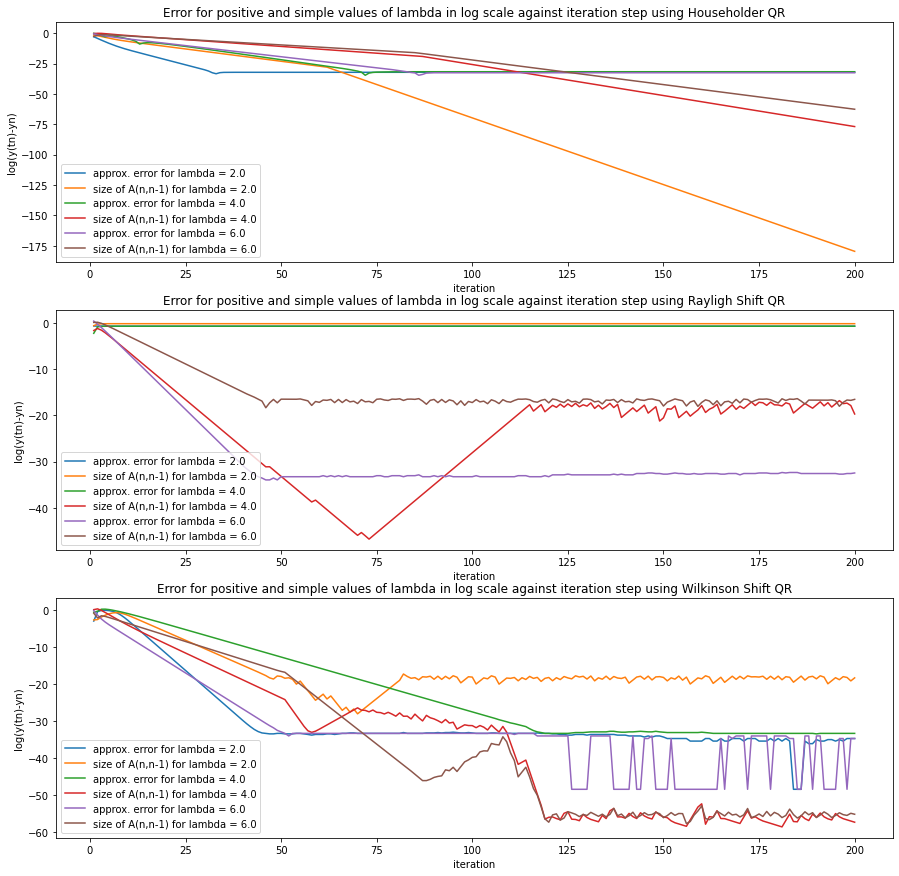

In [28]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=np.identity(n)
for i in range(n):
    L[i][i]=i+1

A=np.array(symm_mat(L))
result=HouseholderQR(A)

chosen=[1,3,5]

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
        
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for positive and simple values of lambda in log scale against iteration step using Householder QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=RayleighQR (A)#print ("This is what I get with RQ : ", result)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for positive and simple values of lambda in log scale against iteration step using Rayligh Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
result=WilkinsonQR (A)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for positive and simple values of lambda in log scale against iteration step using Wilkinson Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

plt.show()

>The first graph is what we get if we plot the error between the true value of lambda and the eigenvalue computed with Householder QR algorithm. We can see that this algorithm is quite stable. It isn't very fast but all eigenvalues converge eventually. We also have the plot of the size of the off diagonal entry corersponding to the targetted eigenvalue, we see that they decay in a linear fashion.

>Then we have plotted the approximation error and the size of the off-diagonal entry when using the QR algorithm with Rayleigh shifts. This techinque converges really quickly for the dominating eigenvalue but stays way off for the others. 

>The last technique seems the better of the three. The convergence is fast for all eigenvalues, not just the dominating one. The middle sized one seems to take a little bit longer to converge but it's comparable to the Householder QR result so the Wilkinson shift techinque still comes out ahead. We note that the weird plateaus in the approximation error for lambda=6 is due to the fix in the log_scale function. Some value in err[] were zero so when they arrived in the log_Scale function a math.domain error popped out ($\log(0)$ is undefined). We made the convention that $\log(0)$= $\log(\epsilon^3)$.

# Part 6. Experimenting on different sets of eigenvalues :

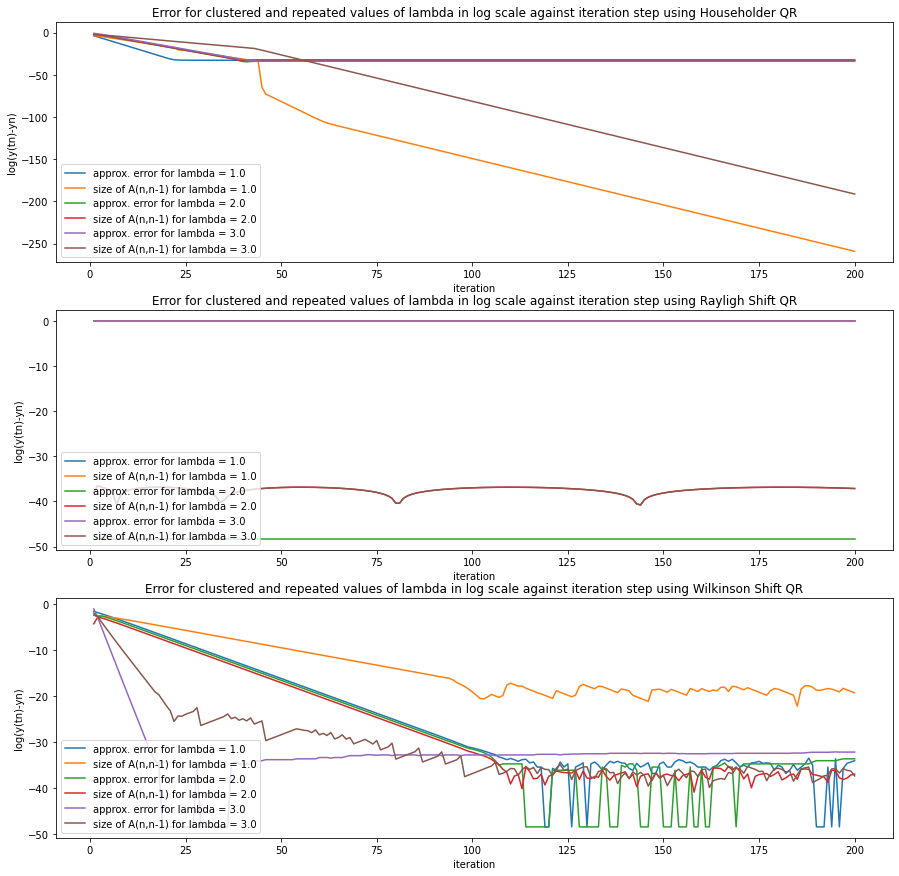

In [29]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[1.,0.,0.,0.,0.,0.],
   [0.,2.,0.,0.,0.,0.],
   [0.,0.,2.,0.,0.,0.],
   [0.,0.,0.,2.,0.,0.],
   [0.,0.,0.,0.,2.,0.],
   [0.,0.,0.,0.,0.,3.]]

A=np.array(symm_mat(L))
result=HouseholderQR(A)

chosen=[0,3,5]

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
        
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for clustered and repeated values of lambda in log scale against iteration step using Householder QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=RayleighQR (A)#print ("This is what I get with RQ : ", result)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for clustered and repeated values of lambda in log scale against iteration step using Rayligh Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
result=WilkinsonQR (A)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for clustered and repeated values of lambda in log scale against iteration step using Wilkinson Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

plt.show()

>Here we have clustered and repeated eigenvalues (1, 2 with multiplicity 4 and 3). We observe that Householder QR still converges homogeneously and still slowly. This techinque seem to be stable.

>The Rayleigh QR algorithm however gives alarming results : it looks like the repeated eigenvalue is found neary immideately but that the others just never converge. This is somewhat consistent with the results observed in part 5).

>For the Wilkinson Shift QR we observe an interesting behavior for the approximation of lambda=2., it looks like the multiplicity slowed down the convergence of the smaller eigenvalue(1.0), while speeding up the convergence of 3.0

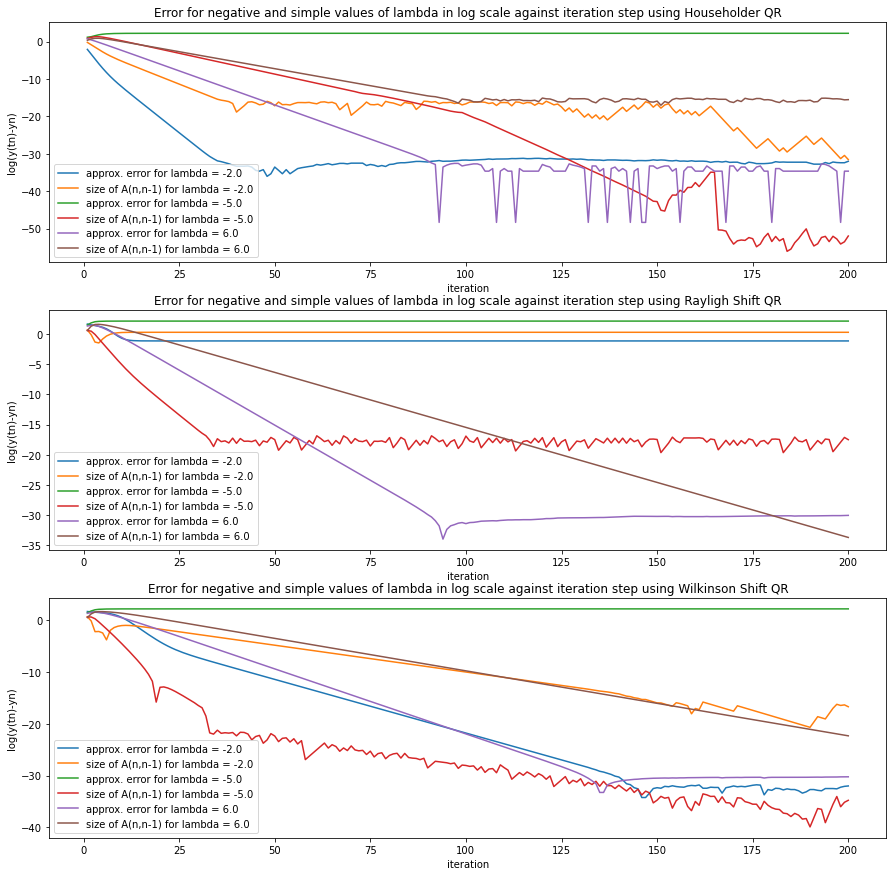

In [30]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[1.,0.,0.,0.,0.,0.],
   [0.,-2.,0.,0.,0.,0.],
   [0.,0.,3.,0.,0.,0.],
   [0.,0.,0.,4.,0.,0.],
   [0.,0.,0.,0.,-5.,0.],
   [0.,0.,0.,0.,0.,6.]]

A=np.array(symm_mat(L))
result=HouseholderQR(A)

chosen=[1,4,5]

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
        
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for negative and simple values of lambda in log scale against iteration step using Householder QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=RayleighQR (A)#print ("This is what I get with RQ : ", result)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for negative and simple values of lambda in log scale against iteration step using Rayligh Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
result=WilkinsonQR (A)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for negative and simple values of lambda in log scale against iteration step using Wilkinson Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

plt.show()

> We observe that Householder QR is completely thrown off by negative eigenvalues. The convergence totally lost it's stability and $\lambda$= 5 doesn't even converge. 

> The Rayleigh Shift method howver isn't very affected, we still have rapid convergence of the dominating eigenvalue

> On the other hand Wilkinson Shift QR is greatly slowed down for negative eigenvalue. We conclude that doing a pre formatting of the matrix before applyng the QR algorithm is a rewarding approach.

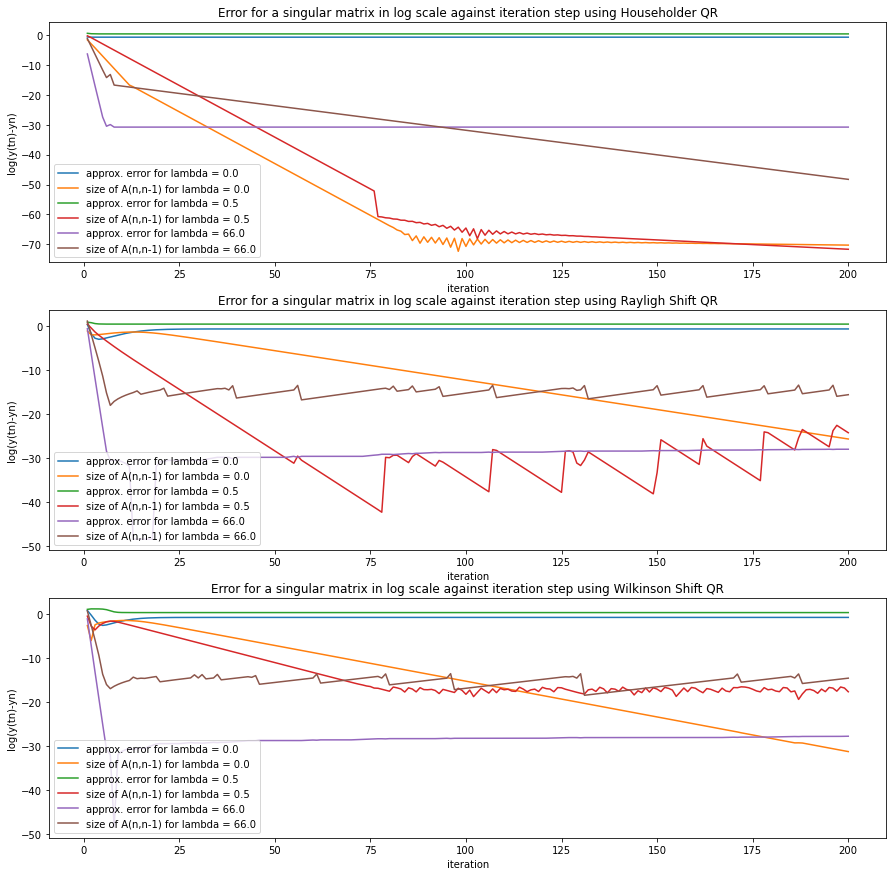

In [31]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[2.,0.,0.,0.,0.,0.],
   [0.,0.,0.,0.,0.,0.],
   [0.,0.,.5,0.,0.,0.],
   [0.,0.,0.,4.,0.,0.],
   [0.,0.,0.,0.,5.,0.],
   [0.,0.,0.,0.,0.,66.]]

A=np.array(symm_mat(L))
result=HouseholderQR(A)

chosen=[1,2,5]

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
        
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for a singular matrix in log scale against iteration step using Householder QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=RayleighQR (A)#print ("This is what I get with RQ : ", result)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for a singular matrix in log scale against iteration step using Rayligh Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
result=WilkinsonQR (A)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for a singular matrix in log scale against iteration step using Wilkinson Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

plt.show()

>There are three characteristics being studied here : the matrix is singular, has a small eigenvalue ($\lambda$ = 0.5) and a relativel large one ($\lambda$= 66).

> All three QR algorithms approximate $\lambda$= 66 farily well, but completely miss 0.0 and 0.5, which is expected for RS QR but we suspect this is a consequence of the singularity of A for HH and Wilkinson.

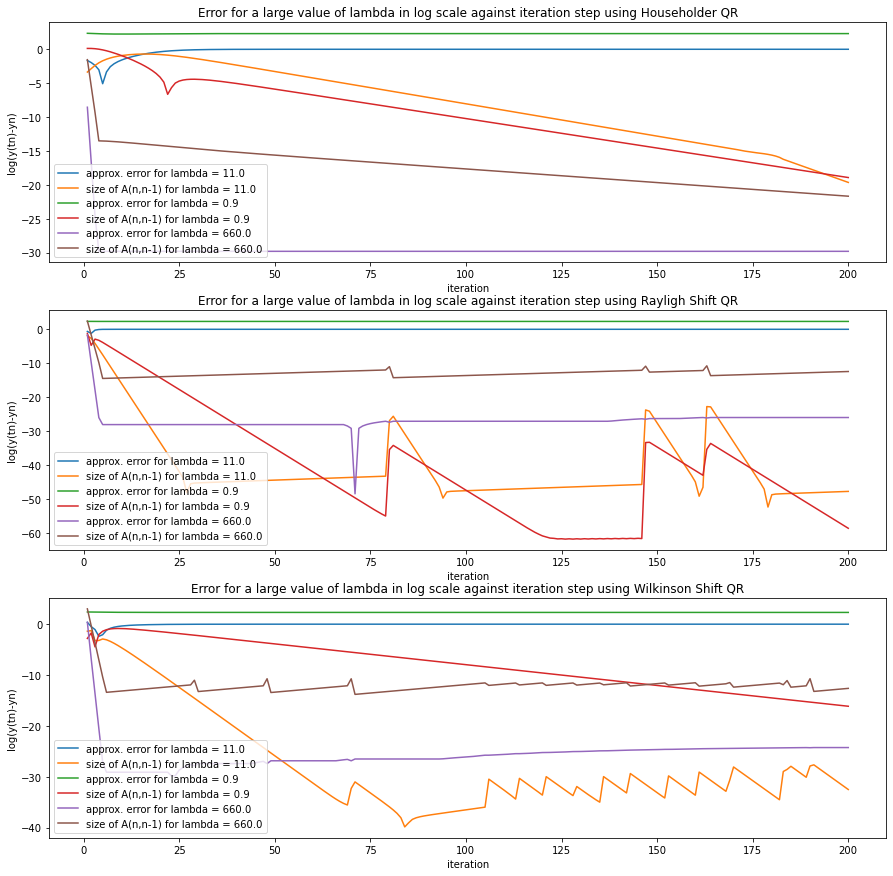

In [32]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[10.,0.,0.,0.,0.,0.],
   [0.,11.,0.,0.,0.,0.],
   [0.,0.,.9,0.,0.,0.],
   [0.,0.,0.,12.,0.,0.],
   [0.,0.,0.,0.,13.,0.],
   [0.,0.,0.,0.,0.,660.]]

A=np.array(symm_mat(L))
result=HouseholderQR(A)

chosen=[1,2,5]

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
        
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for a large value of lambda in log scale against iteration step using Householder QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=RayleighQR (A)#print ("This is what I get with RQ : ", result)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for a large value of lambda in log scale against iteration step using Rayligh Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
result=WilkinsonQR (A)

index_list=find_index(result[len(result)-1])
for choice in chosen:
    data=get_data (result, choice, index_list)
            
        
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for a large value of lambda in log scale against iteration step using Wilkinson Shift QR')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")


>This experiment with 5 clustered eigenvalues and one relatively large ($\lambda$=660.0) shows that the previous hypothesis wasn't correct. It seems that the large dominating eigenvalue is throwing off the convegence of the smaller ones for all three techniques.

# Part 7. QR algorithm with deflations

In [33]:
def Householder (B):
    #performs QR algorithm recursively on minors of an nxn matrix B using HH
    M=[]
    data=[]
    K=0
    for i in range(len(B)-1):
        k=1
        data.append([K+k,B])
        while checkoffdiag(B):
            k+=1
            QR=HH(B)
            B = np.matmul(QR[1], QR[0])
            data.append([K+k, B])#print ("k is :",k)
        K+=k
        M.append([K, B[len(B)-1]])
        B=extract_major(B)
    M.append([K+1, np.array(B[0])])
    data.append([K+1, np.array(B)])#print ("This what I've kept track off :", data)
    return [M, data]

In [34]:
def Rayleigh (B):
    #performs QR algorithm recursively on minors of an nxn matrix B using Rayleigh shifts
    M=[]
    data=[]
    K=0
    for i in range(len(B)-1):
        k=1
        data.append([K+k,B])
        while checkoffdiag(B):
            k+=1
            nu=RQ(B)
            B=B-nu*np.identity(len(B))
            QR=HH(B)
            B=np.matmul(QR[1], QR[0])+nu*np.identity(len(B))
            data.append([K+k, B])
        K+=k
        M.append([K, B[len(B)-1]])
        B=extract_major(B)
    M.append([K+1, np.array(B[0])])
    data.append([K+1, np.array(B)])
    return [M, data]

In [35]:
def Wilkinson(B):
    #performs QR algorithm recursively on minors of an nxn matrix B using Wilkinson shifts
    M=[]
    data=[]
    K=0
    for i in range(len(B)-1):
        k=1
        data.append([K+k,B])
        while checkoffdiag(B):
            k+=1
            nu=WS(B)
            B=B-nu*np.identity(len(B))
            QR=HH(B)
            B=np.matmul(QR[1], QR[0])+nu*np.identity(len(B))
            data.append([K+k, B])
        K+=k
        M.append([K, B[len(B)-1]])
        B=extract_major(B)
    M.append([K+1, np.array(B[0])])
    data.append([K+1, np.array(B)])
    return [M, data]

Graphing Helpers part 2:

In [36]:
def find_index_2 (liste):
    #I have another version of this but since here I'm feeding n vectors of decreasing length I can't use it without
    #heavily modifying it so might as well write a specific function for this
    array=[]
    for i in range(len(liste)):
        array.append(liste[len(liste)-1-i][1])
    #print ("This is the mat : ", array)
    eigs=[]
    for i in range(len(array)):
        eigs.append(array[i][len(array[i])-1])
    copie=sorted(eigs, key=float)
    index_list=[]
    for eig in copie:
        for j in range(len(eigs)):
            if eigs[j]==eig:
                index_list.append(j)
    return index_list

In [37]:
def get_data_2 (result, choice, liste):
    #I also have something similar up there but I don't think it's worth generalising it, I'd rather code something 
    #specific to the format I'm feeding here
    index=liste[choice]
    #print ("This is the index :", index)
    it_size=result[0][len(result[0])-1-index][0]
    #print ("it size :",it_size )
    it=[i for i in range(it_size)]
    err=[]
    size=[]
    data=result[1]
    for i in range(it_size):
        #print ("We're at i=", i)
        n=len(data[i][1])
        #print ("This is the size of this array :", n)
        #print ("Is this what I think it it? ", data[i][1][index][index])
        err.append(abs(data[i][1][index][index]-L[choice][choice]))
        if index>0:
            size.append(abs(data[i][1][index][index-1]))
        else:
            if n>1:
                size.append(abs(data[i][1][index+1][index]))
            else :
                size.append(size[i-1])
    return [it, err, size]

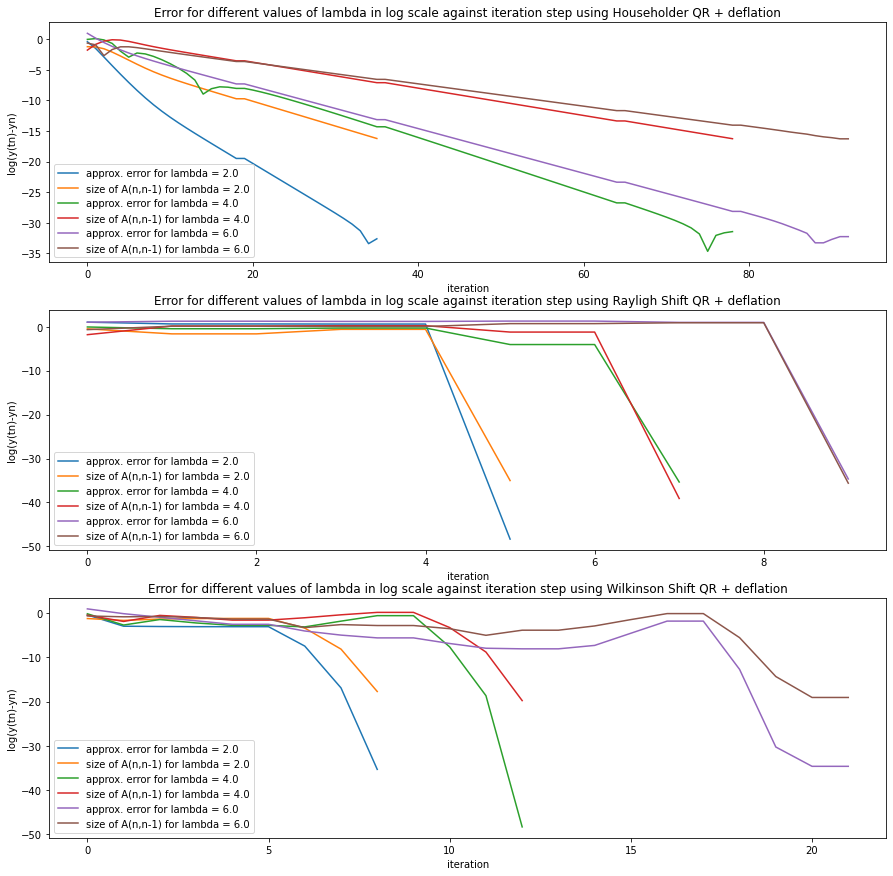

In [38]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=np.identity(n)
for i in range(n):
    L[i][i]=i+1

chosen=[1,3,5]

A=np.array(symm_mat(L))
result=Householder(A)#print ("This is what I get with HH :", result[0])
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for different values of lambda in log scale against iteration step using Householder QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=Rayleigh(A)#print ("This is what I get with RS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for different values of lambda in log scale against iteration step using Rayligh Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
    
result=Wilkinson(A)#print ("This is what I get with WS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for different values of lambda in log scale against iteration step using Wilkinson Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")
    

>This implementation clearly shows that the three versions of the QR algorithm behave intrensically differently. The set of eigenvalues chosen here is particularly nice, but it is still worth mentioning that the Rayleigh shift technique is by far most efficient

> Also the extra work of implementing the deflation was worth it since we're getting a much faster convergence for all three techniques.

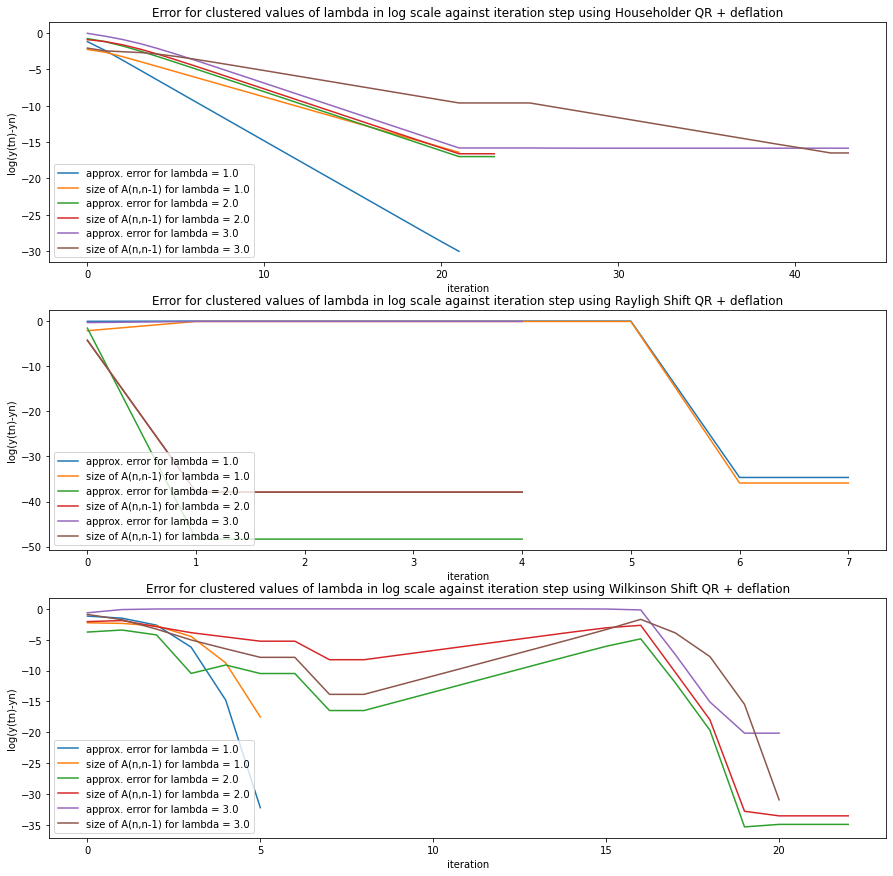

In [39]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[1.,0.,0.,0.,0.,0.],
   [0.,2.,0.,0.,0.,0.],
   [0.,0.,2.,0.,0.,0.],
   [0.,0.,0.,2.,0.,0.],
   [0.,0.,0.,0.,2.,0.],
   [0.,0.,0.,0.,0.,3.]]

chosen=[0,3,5]

A=np.array(symm_mat(L))
result=Householder(A)#print ("This is what I get with HH :", result[0])
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for clustered values of lambda in log scale against iteration step using Householder QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=Rayleigh(A)#print ("This is what I get with RS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for clustered values of lambda in log scale against iteration step using Rayligh Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
    
result=Wilkinson(A)#print ("This is what I get with WS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for clustered values of lambda in log scale against iteration step using Wilkinson Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

> Experimenting with a set of clustered eigenvalues (1, 2 with multiplicity 4 and 3) shows that the Rayleigh shift method may be overall the best when implemented with a deflation process.

>We see that even with the deflation, the smaller eigenvalue is still really hard to approximate.

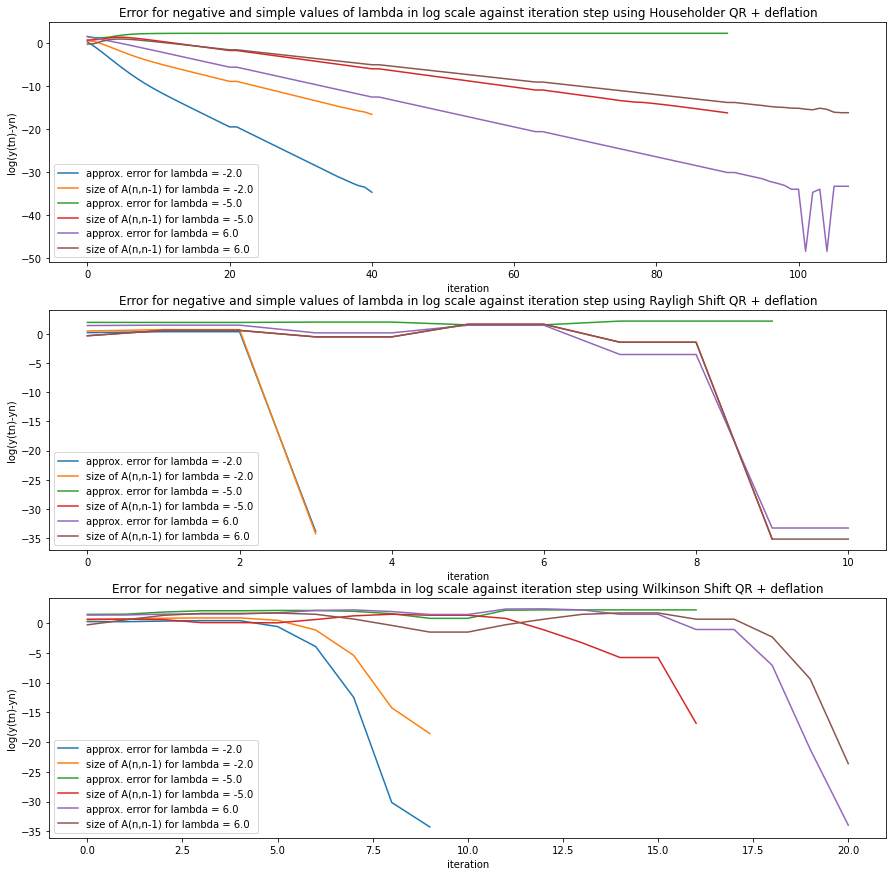

In [40]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[1.,0.,0.,0.,0.,0.],
   [0.,-2.,0.,0.,0.,0.],
   [0.,0.,3.,0.,0.,0.],
   [0.,0.,0.,4.,0.,0.],
   [0.,0.,0.,0.,-5.,0.],
   [0.,0.,0.,0.,0.,6.]]

chosen=[1,4,5]

A=np.array(symm_mat(L))
result=Householder(A)#print ("This is what I get with HH :", result[0])
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for negative and simple values of lambda in log scale against iteration step using Householder QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=Rayleigh(A)#print ("This is what I get with RS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for negative and simple values of lambda in log scale against iteration step using Rayligh Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
    
result=Wilkinson(A)#print ("This is what I get with WS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for negative and simple values of lambda in log scale against iteration step using Wilkinson Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

>Unsurprisingly the algorithms are very disturbed by the negative eigenvalues, even more so than without the deflation.

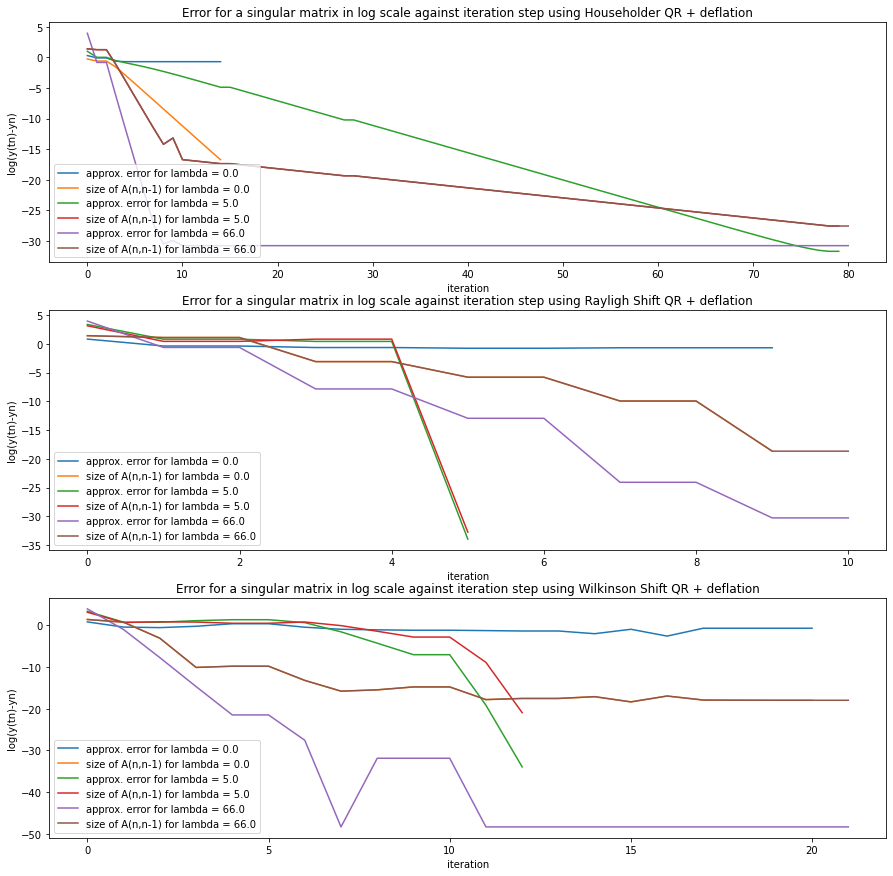

In [41]:
mu=0.
sigma=1.
rd.seed(1)
eps=0.0000001
n=6
itHH=200

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(15,15))

L=[[2.,0.,0.,0.,0.,0.],
   [0.,0.,0.,0.,0.,0.],
   [0.,0.,.5,0.,0.,0.],
   [0.,0.,0.,4.,0.,0.],
   [0.,0.,0.,0.,5.,0.],
   [0.,0.,0.,0.,0.,66.]]

chosen=[1,4,5]

A=np.array(symm_mat(L))
result=Householder(A)#print ("This is what I get with HH :", result[0])
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax1.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax1.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax1.set_title(r'Error for a singular matrix in log scale against iteration step using Householder QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax1.set_xlabel(r'iteration')
    ax1.set_ylabel('log(y(tn)-yn)')
    ax1.legend(loc="lower left")
    
result=Rayleigh(A)#print ("This is what I get with RS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax2.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax2.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax2.set_title(r'Error for a singular matrix in log scale against iteration step using Rayligh Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax2.set_xlabel(r'iteration')
    ax2.set_ylabel('log(y(tn)-yn)')
    ax2.legend(loc="lower left")
    
    
result=Wilkinson(A)#print ("This is what I get with WS :", result)
index_list=find_index_2 (result[0])#print (index_list)
for choice in chosen:
    data= get_data_2 (result, choice, index_list)
    
    ax3.plot(data[0],logscale(data[1]), label='approx. error for lambda = {}'.format(L[choice][choice]))
    ax3.plot(data[0],logscale(data[2]) ,label='size of A(n,n-1) for lambda = {}'.format(L[choice][choice]))
    ax3.set_title(r'Error for a singular matrix in log scale against iteration step using Wilkinson Shift QR + deflation')#ax1.xaxis.set_label_coords(.5,.06)
    ax3.set_xlabel(r'iteration')
    ax3.set_ylabel('log(y(tn)-yn)')
    ax3.legend(loc="lower left")

>This time the deflation really helps going around the singularity of the matrix. This implementation is recommended in this case.